In [ ]:
# requirement
#!pip install sbi

In [ ]:
#!pip install --upgrade numpy xarray arviz packaging

In [ ]:
!nvcc --version

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# general
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torch.distributions import Distribution
from tqdm import tqdm

# Numpyro
# import numpyro
# import numpyro.distributions as npdist
# import random as rnd
# from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
# from numpyro.diagnostics import hpdi

#numpyro.set_host_device_count(4)

#JAX version 0.4.31
import jax
from jax import random
import jax.numpy as jnp

#SBI
from sbi.inference import  prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

# check versions
#print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

# code agnostic device
device="cuda" if torch.cuda.is_available() else "cpu"

0.4.23
2.1.0+cpu-cxx11-abi
3.10.12


In [ ]:
#@title requirements
try:
  from utils import install_packages
except:
  # Colab
  !git clone https://github.com/mackelab/simformer.git
  from simformer.example.utils import install_packages
  from google.colab import output
  output.enable_custom_widget_manager()

install_packages()  # install required packages

In [ ]:
# Jax version 0.4.23
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array
import os


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from functools import partial
from typing import Tuple, List, Optional

# Some small helper functions
from probjax.distributions.sde import VESDE
import haiku as hk # Neural network library
import optax # Gradient-based optimization in JAX
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions import Empirical, Independent
from scoresbibm.utils.plot import use_style
from sbi.analysis import pairplot
import numpy as np
jax.devices() # Should be cuda
_ = os.system("nvidia-smi  --query-gpu=name --format=csv,noheader") # Should show GPU info


In [ ]:
#@title   GP kernel ( RBK )  &  1d GP generator
def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = z.reshape(z.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def gp_kernel(x, z, sigma, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = (sigma**2) * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k


#GP Generator
def GP(x, jitter=1e-5, sigma=1.0, length=None, y=None, noise=False, gp_kernel=gp_kernel):

    if length==None:
        length = numpyro.sample("length", npdist.Uniform(0.01,0.99))

    k = gp_kernel(x, x, sigma, length, jitter)

    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        epsilon = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, epsilon), obs=y)

    ls = numpyro.deterministic("ls", jnp.array([length]))

In [ ]:
args = {"seed": 0,
     "n_datapoint":80,
        "n_samples":5000,
        "true_ls": 0.2,
        "x_lim_low": 0,
        "x_lim_high": 1,
        "true_ls":0.2,
        "true_sigma":1,
       }

In [ ]:
x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])

In [ ]:
#@title Ground truth & Observed data points
x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])

rng_key_draw =  random.PRNGKey(9)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive( rng_key_draw,x=x, jitter=1e-6,noise=True, length=args["true_ls"], sigma=args["true_sigma"])
gp_draw = draws['f'].T
y_draw = draws['y'].T

obs_idx_lst = []
obs_idx_lst.append([10, 30, 54, 64,75]) # points correspond to n=80, ls=0.2, sigma=0.5
i = 0

# choose indices of data points for inference
obs_idx = jnp.array(obs_idx_lst[i])

y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

args['y_obs'] = y_obs
args['obs_idx'] = obs_idx
args['x_obs'] = x_obs

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to :  ls=' + str(args["true_ls"])+',sigma='+str(args["true_sigma"]))
plt.legend()

In [ ]:
#@title Ground truth & Observed data points
x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6,
                      noise=True, length=args["true_ls"], sigma=args["true_sigma"])

gp_draw = draws['f'].T
y_draw = draws['y'].T

obs_idx_lst = []
obs_idx_lst.append([10, 30, 54, 64,75]) # points correspond to n=80, ls=0.2, sigma=0.5
i = 0

# choose indices of data points for inference
obs_idx = jnp.array(obs_idx_lst[i])

y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

args['y_obs'] = y_obs
args['obs_idx'] = obs_idx
args['x_obs'] = x_obs

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to :  ls=' + str(args["true_ls"])+',sigma='+str(args["true_sigma"]))
plt.legend()

In [ ]:
#@title  GP RBK kernel ( pythorch version)
x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])
x = torch.tensor(x).type(torch.float32)

def dist_euclid(x, z):
    x = torch.as_tensor(x)
    z = torch.as_tensor(z)
    if len(x.shape) == 1:
        x = x.unsqueeze(1)
    if len(z.shape) == 1:
        z = z.unsqueeze(1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = torch.zeros((n_x, n_z))
    for d in range(m):
        x_d = x[:, d]
        z_d = z[:, d]
        delta += (x_d[:, None] - z_d) ** 2
    return torch.sqrt(delta)

def gp_kernel(ls ,x=x, z=x,sigma=1, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = torch.pow(dist / ls, 2.0)
    k = (sigma ** 2) * torch.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * torch.eye(x.shape[0], device=x.device)
    return k


##The Matérn kernel

The Matérn kernel (or Matérn covariance function) is a popular kernel used in Gaussian Process (GP) models, particularly for modeling spatial data. It controls the smoothness of the functions generated by the GP. The Matérn kernel is more flexible than the commonly used squared exponential (RBF) kernel because it has an additional parameter that controls the smoothness of the function.

$$
k_{\text{Matérn}}(x, x') = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \frac{\sqrt{2\nu} d}{\ell} \right)^\nu K_\nu \left( \frac{\sqrt{2\nu} d}{\ell} \right)
$$

where:
- $ d = \|x - x'\| $ is the Euclidean distance between the two points,
- $\ell $ is the length scale,
- $ \nu $ is the smoothness parameter,
- $ \sigma^2 $ is the variance,
- $ K_\nu $ is the modified Bessel function of the second kind,
- $ \Gamma(\nu) $ is the gamma function.






In [ ]:
import torch
import math
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])
x = torch.tensor(x).type(torch.float32)
# Matérn kernel function
def matern_kernel(ls=1,X=x.unsqueeze(-1), X_prime=x.unsqueeze(-1), nu=2.5, variance=1.0, jitter=1.0e-6):
    """
    Compute the Matérn kernel between two sets of input points.

    Parameters:
    X : torch.Tensor
        A tensor of shape (N, D), where N is the number of points and D is the dimensionality.
    X_prime : torch.Tensor
        A tensor of shape (M, D), where M is the number of points and D is the dimensionality.
    nu : float
        The smoothness parameter of the Matérn kernel. Common values are 0.5, 1.5, and 2.5.
    ls : float
        The length scale parameter, controlling the distance over which correlations decay.
    variance : float
        The variance (amplitude) parameter, controlling the vertical scaling.

    Returns:
    torch.Tensor
        The computed Matérn kernel matrix of shape (N, M).
    """
    # Compute pairwise Euclidean distances between X and X_prime
    distance = torch.cdist(X, X_prime, p=2)  # (N, M)

    # Compute the Matérn kernel based on the value of nu
    if nu == 0.5:
        # Special case: Exponential kernel (Matern with nu=0.5)
        K = torch.exp(-distance / ls)
    elif nu == 1.5:
        sqrt_3 = math.sqrt(3)
        term = sqrt_3 * distance / ls
        K = (1.0 + term) * torch.exp(-term)
    elif nu == 2.5:
        sqrt_5 = math.sqrt(5)
        term = sqrt_5 * distance / ls
        K = (1.0 + term + (term ** 2) / 3.0) * torch.exp(-term)
    else:
        raise NotImplementedError("Matérn kernel with arbitrary nu is not implemented.")
    K= K + jitter * torch.eye(K.shape[0])    # ensure numerical stability
    # Scale by variance
    return variance * K


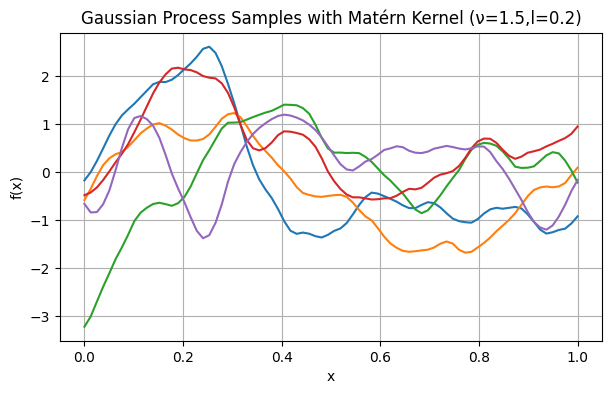

In [ ]:
#@title Exemple samples in 1D
# Step 1: Generate 1D points
N = 80  # Number of points

# Step 2: Compute the covariance matrix using the Matérn kernel
nu = 2.5  # Smoothness parameter
length_scale = 0.1  # Length scale
variance = 1.0  # Variance

cov_matrix = matern_kernel(ls=length_scale,variance = 1.0)

# Step 3: Generate GP samples (mean zero, covariance from Matérn kernel)
mean = torch.zeros(N)  # Zero mean
gp = MultivariateNormal(mean, covariance_matrix=cov_matrix)

# Sample from the GP
samples = gp.sample((5,))  # Generate 3 samples

# Step 4: Plot the GP samples
plt.figure(figsize=(7, 4))
for i in range(5):
    plt.plot(x.numpy(), samples[i].numpy(), label=f'Sample {i+1}')

plt.title('Gaussian Process Samples with Matérn Kernel (ν=1.5,l=0.2)')
plt.xlabel('x')
plt.ylabel('f(x)')
#plt.legend()
plt.grid(True)
plt.show()


\begin{equation}
\theta\sim p(\theta)\\
f\mid \theta\sim
GP(\mu,\Sigma(\theta) )\\
\eta=X\beta +f\\
y\mid \eta \sim p(u^{-1}(\eta),\theta)
\end{equation}

In [ ]:
#@title Version1: prior & Model_simulator (80 params)
class CustomPrior(Distribution):
    def __init__(self, low, high,cov_func):
        super().__init__()
        self.dist1 = dist.Uniform(low=low, high=high)
        #self.dist2 = dist.HalfNormal(scale)
        self.cov_func = cov_func  # Function to compute covariance matrix

    def sample(self, sample_shape=torch.Size()):
        sample1 = self.dist1.sample(sample_shape) # ls
        #sample2 = self.dist2.sample(sample_shape) # epsilon
        # Calculate covariance matrix using the sample from dist1
        if sample1.dim()==0:
          K= self.cov_func(sample1)
          dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          sample3=dist3.sample()
          samples=sample3
        else:
          sample_list=[]
          for ls in sample1:
            K= self.cov_func(ls)   #GP_kernel
            # Create dist3 using the calculated covariance matrix
            dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          # Sample from dist3
            sample_list.append(dist3.sample())
          # combine sample
          sample3= torch.stack(sample_list)

          samples = sample3
        return samples

    def log_prob(self):
        pass

### define the prior and the Model simulator model

## Prior
prior=CustomPrior(low=0.01, high=1, cov_func=gp_kernel)

## Model
def simulator(theta):
  epsilon=dist.HalfNormal(0.1).sample()
  if theta.dim()==1:
    f_gp=theta[np.array(obs_idx)]
  else:
    f_gp=theta[:,np.array(obs_idx)].squeeze()

  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))
  y=dist.MultivariateNormal(mean,cov).sample()
  # y= f_gp + epsilon*torch.randn_like(f_gp)
  return y.unsqueeze(0)


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [ ]:
p=prior.sample()
obs_idx_lst = []
obs_idx_lst.append([10, 30, 54, 64,75]) #points correspond to n=80
i = 0
# choose indices of data points for inference
obs_idx =np.array([10, 30, 54, 64,75])
x_obs = x[np.array(obs_idx)]

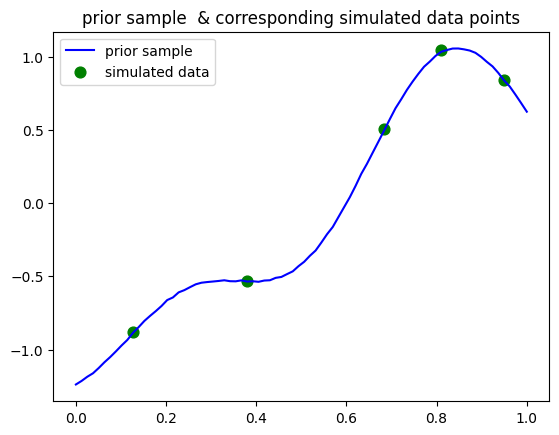

In [ ]:
#@title play with simulations

def play_simul(prior,simulator):
  plt.plot(x.numpy(),prior.numpy(),label="prior sample", color="blue")
  plt.scatter(x_obs, simulator(prior).numpy(), color="green", label="simulated data", s=60)
  plt.title("prior sample  & corresponding simulated data points")
  plt.legend()
  plt.show()
  return simulator(prior).numpy()

y_obs=play_simul(p,simulator)

## Build a Conditional invertible Neural Network (cINN)

In [ ]:
#@title 1st model conf
# input_dim = 80  #  input dimension
# condition_dim = 5  #  conditioning dimension
# num_layers = 8  # Number of coupling layers

In [ ]:
input_dim = 80  #  input dimension
condition_dim = 5  #  conditioning dimension
num_layers = 8  # Number of coupling layers

In [ ]:
#@title define a permutation matrix (orthogonal)
def permutation_matrix(n):
    # Create an identity matrix of size n
    P = torch.eye(n, dtype=torch.float32)
    # Randomly permute the rows of the identity matrix
    P = P[torch.randperm(n), :]
    return P

In [ ]:
#@title permutation layer
class PermutationLayer(nn.Module):
    def __init__(self, input_dim,Q):
        super().__init__()
        self.input_dim = input_dim
        # Create a fixed permutation matrix
        self.permutation = nn.Parameter(Q, requires_grad=False)

    def forward(self, x):
        # Apply the permutation matrix Q to the input
        return torch.matmul(x, self.permutation)

    def inverse(self, z):
        # Apply the inverse permutation (transpose of the permutation matrix)
        return  torch.matmul(z,self.permutation.t())

In [ ]:
#@title coupling layer model
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, input_dim // 2),
            nn.Tanh()  # To keep scale between -1 and 1
        )
        self.shift_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, input_dim // 2)
        )

    def forward(self, x, condition):
        x1, x2 = torch.chunk(x, 2, dim=1)
        # Concatenate x2 with the conditioning input
        x2_conditioned = torch.cat([x2, condition], dim=1)
        scale = self.scale_net(x2_conditioned)
        shift = self.shift_net(x2_conditioned)
        z1 = x1 * torch.exp(scale) + shift
        z2 = x2
        log_det_jacobian = scale.sum(dim=-1)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det_jacobian

    def inverse(self, z, condition):
        z1, z2 = torch.chunk(z, 2, dim=1)
        # Concatenate z2 with the conditioning input
        z2_conditioned = torch.cat([z2, condition], dim=1)
        scale = self.scale_net(z2_conditioned)
        shift = self.shift_net(z2_conditioned)
        x1 = (z1 - shift) * torch.exp(-scale)
        x2 = z2
        log_det_jacobian = -scale.sum(dim=-1)
        x = torch.cat([x1, x2], dim=1)
        return x, log_det_jacobian


In [ ]:
#@title complete cINN architecture
class ConditionalInvertibleNN(nn.Module):
    def __init__(self, input_dim, condition_dim, num_layers,Q):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(AffineCouplingLayer(input_dim, condition_dim))
            self.layers.append(PermutationLayer(input_dim,Q))

    def forward(self, x, condition):
        log_det_jacobian_total = 0
        for layer in self.layers[:-1]:
            if isinstance(layer, AffineCouplingLayer):
                x, log_det_jacobian = layer(x, condition)
            else:
                x = layer(x)
            log_det_jacobian_total += log_det_jacobian
        return x, log_det_jacobian_total

    def inverse(self, z, condition):
        log_det_jacobian_total = 0
        for layer in reversed(self.layers[:-1]):
            if isinstance(layer, AffineCouplingLayer):
                z, log_det_jacobian = layer.inverse(z, condition)
            else:
                z = layer.inverse(z)
            log_det_jacobian_total += log_det_jacobian
        return z, log_det_jacobian_total


In [ ]:
#@title test

Q=permutation_matrix(input_dim)
model = ConditionalInvertibleNN(input_dim, condition_dim, num_layers,Q)

### test

# Example input and condition
x = torch.randn(10, input_dim)
condition = torch.randn(10, condition_dim)

# Forward pass
z, log_det_jacobian = model(x, condition)

# Inverse pass (to reconstruct the original input given the condition)
x_reconstructed, _ = model.inverse(z, condition)

# print("Original x:", x)
# print("Transformed z:", z)
# print("Reconstructed x:", x_reconstructed)


In [ ]:
#@title define the Loss function ( Negative log Likelihood ) & Latent space prior ( Standard Gaussian)
# Loss
class NLLLoss(nn.Module):
    def __init__(self):
        super().__init__()
       # base distribution
       # Typically a standard normal distribution

    def forward(self, z, log_det_jacobian):
      #log_prob=self.dist.log_prob(z)
      log_prob = -0.5 * z.pow(2).sum(dim=-1) - 0.5 * z.size(1) * torch.log(torch.tensor(2 * torch.pi))
      nll = - (log_prob+ log_det_jacobian)
      return nll.mean()
# Latent space prior : P(z)

input_dim=80
mean=torch.zeros(input_dim)
Cov=torch.eye(input_dim)
P_z =dist.MultivariateNormal(mean,Cov)

In [ ]:
#@title training loop
def train_cINN(model, optimizer,nll_loss, data_loader, num_epochs):
    train_loss=[]
    model.train()
    for epoch in range(num_epochs):
        for x, cond in data_loader:

            # Forward pass
            z, log_det_jacobian = model(x, cond)
            # calculate the loss
             # # Assume the base distribution is standard Gaussian
            log_prob = -0.5 * z.pow(2).sum(dim=-1) - 0.5 * x.size(1) * torch.log(torch.tensor(2 * torch.pi))
            loss = - (log_prob + log_det_jacobian).mean()
            #loss=nll_loss(x,  z, log_det_jacobian)
            # optimizer zero grad
            optimizer.zero_grad()

            # Backpropagation
            loss.backward()
            # Optimize step
            optimizer.step()


            train_loss.append(loss)
        if epoch % 10==0:
          print(f"Epoch: {epoch} | Loss: {loss}")

## Setup

input_dim = 80  #  input dimension
condition_dim = 5  #  conditioning dimension
num_layers = 3  # Number of coupling layers
Q=permutation_matrix(input_dim)   # permutation matrix ( orthogonal )

model = ConditionalInvertibleNN(input_dim, condition_dim, num_layers,Q)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
nll_loss=NLLLoss(P_z)

# code agnostic device


In [ ]:
#@title prepare for training
def train_cINN(x,cond, model, optimizer, num_epochs):
    train_loss=[]
    model.train()
    for epoch in range(num_epochs):
      #for x, cond in data_loader:

      # Forward pass
      z, log_det_jacobian = model(x, cond)
      # calculate the loss
      loss=loss_fn(z,log_det_jacobian)

      # optimizer zero grad
      optimizer.zero_grad()

      # Backpropagation
      loss.backward()
      # Optimize step
      optimizer.step()
      train_loss.append(loss)
      if epoch % 50==0:
        print(f"Epoch: {epoch} | Loss: {loss}")
    return train_loss


In [ ]:
Q=permutation_matrix(input_dim)   # permutation matrix ( orthogonal )
model = ConditionalInvertibleNN(input_dim, condition_dim, num_layers,Q).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn=NLLLoss()

In [ ]:
#@title Define both Model (simulator ) and Prior over params (80 params)
class CustomPrior(Distribution):
    def __init__(self, low, high,cov_func):
        super().__init__()
        self.dist1 = dist.Uniform(low=low, high=high)
        #self.dist2 = dist.HalfNormal(scale)
        self.cov_func = cov_func  # Function to compute covariance matrix

    def sample(self, sample_shape=torch.Size()):
        sample1 = self.dist1.sample(sample_shape) # ls
        #sample2 = self.dist2.sample(sample_shape) # epsilon
        # Calculate covariance matrix using the sample from dist1
        if sample1.dim()==0:
          K= self.cov_func(sample1)
          dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          sample3=dist3.sample()
          samples=sample3
        else:
          sample_list=[]
          for ls in sample1:
            K= self.cov_func(ls)   #GP_kernel
            # Create dist3 using the calculated covariance matrix
            dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          # Sample from dist3
            sample_list.append(dist3.sample())
          # combine sample
          sample3= torch.stack(sample_list)

            # Concatenate sample1, sample2, and sample3 along the last dimension
          samples = sample3
        return samples

    def log_prob(self):
        pass

### define the prior and the Model simulator model

## Prior
prior=CustomPrior(low=0.01, high=1, cov_func=gp_kernel)

## Model
def model_simulator(theta):
  epsilon=dist.HalfNormal(0.1).sample()
  if theta.dim()==1:
    f_gp=theta[np.array(obs_idx)]
  else:
    f_gp=(theta[:,np.array(obs_idx)]).squeeze()

  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))
  y=dist.MultivariateNormal(mean,cov).sample()
  # y= f_gp + epsilon*torch.randn_like(f_gp)
  return y.unsqueeze(0)


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [ ]:
#@title Simulate synthetic data for training ( 20000 simulated samples).
theta, y = simulate_for_sbi(model_simulator, proposal=prior, num_simulations=20000)

Running 20000 simulations.:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
print(f"params  (theta) dim: {theta.shape},\nconditioning (y) dim: {y.shape}")

params  (theta) dim: torch.Size([20000, 80]),
conditioning (y) dim: torch.Size([20000, 5])


In [ ]:
#@title dataloader
from torch.utils.data import Dataset, DataLoader
class theta_cond_Dataset(Dataset):
    def __init__(self, theta, y):
        self.theta = theta
        self.y = y

    def __len__(self):
        return len(self.theta)

    def __getitem__(self, idx):
        return self.theta[idx], self.y[idx]

dataset=theta_cond_Dataset(theta.to(device), y.to(device))
dataloader= DataLoader(dataset, batch_size=128, shuffle=True)


params  (theta) dim: torch.Size([10000, 80]),
conditioning (y) dim: torch.Size([10000, 5])


In [ ]:
#@title training
train_loss=train_cINN(theta.to(device),y.to(device), model, optimizer,num_epochs=1000)

Epoch: 0 | Loss: 131.92764282226562
Epoch: 50 | Loss: -102.99353790283203
Epoch: 100 | Loss: -232.340087890625
Epoch: 150 | Loss: -280.679443359375
Epoch: 200 | Loss: -305.6782531738281
Epoch: 250 | Loss: -317.3097229003906
Epoch: 300 | Loss: -329.7081298828125
Epoch: 350 | Loss: -342.7655029296875
Epoch: 400 | Loss: -346.09600830078125
Epoch: 450 | Loss: -357.16632080078125
Epoch: 500 | Loss: -355.1684265136719
Epoch: 550 | Loss: -366.9091796875
Epoch: 600 | Loss: -371.0902404785156
Epoch: 650 | Loss: -375.9809265136719
Epoch: 700 | Loss: -380.1229553222656
Epoch: 750 | Loss: -382.7978515625
Epoch: 800 | Loss: -385.7839050292969
Epoch: 850 | Loss: -306.92108154296875
Epoch: 900 | Loss: -390.7342224121094
Epoch: 950 | Loss: -392.97900390625


Text(0.5, 1.0, 'training loss')

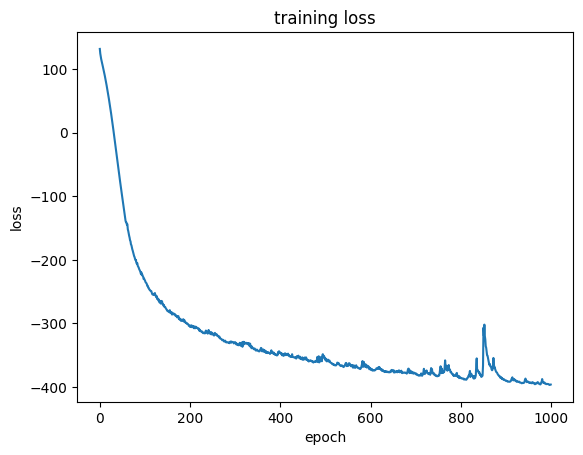

In [ ]:
train_loss=torch.tensor(train_loss)
plt.plot(np.arange(len(train_loss)),train_loss.numpy())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("training loss")

In [ ]:
#model.load_state_dict(torch.load("/content/model_it7.pth"))
#model.load_state_dict(torch.load("/content/model_it7.pth"))

<All keys matched successfully>

In [ ]:
#@title Learned Posterior
class LearnPosterior(Distribution):
    def __init__(self,y_o,base_dist,model,device):
        super().__init__()
        self.y=y_o # conditioning variable
        self.P_z=base_dist # base distribution
        self.model=model # trained model ( cINN )
        self.device= device # device
    def sample(self,sample_shape=torch.Size()):
        self.model.eval()
        with torch.inference_mode():
          n=sample_shape[0]
          f_post,_=self.model.inverse(self.P_z.sample((n,)).to(self.device),self.y.repeat(n,1).to(self.device))
          if self.device=="cuda":
            f_post=f_post.cpu()
        return f_post

## Model
def Post_predictive(theta):
  epsilon=dist.HalfNormal(0.1).sample()
  if theta.dim()==1:
    f_gp=theta                                        #[np.array(obs_idx)]
  else:
    f_gp=theta.squeeze()

  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))
  y=dist.MultivariateNormal(mean,cov).sample()
  # y= f_gp + epsilon*torch.randn_like(f_gp)
  return y.unsqueeze(0)

## Use .sample() method to sample from the learned posterior
#Learned_posterior=LearnPosterior(y_o,P_z,model,device)

In [ ]:
x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

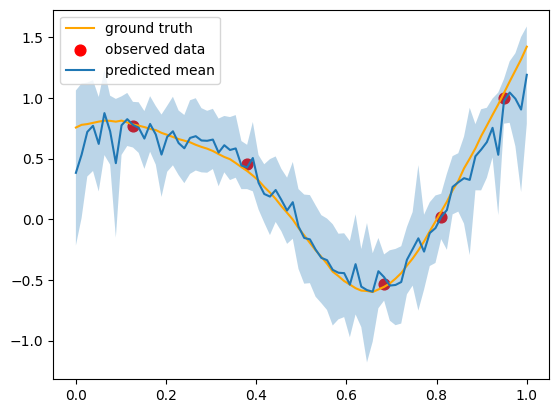

In [ ]:
#@title Posterior predictive
theta_post, y_pred = simulate_for_sbi(Post_predictive, proposal=Learned_posterior, num_simulations=5000)
predictions=y_pred.numpy()

#plot
mean_post_pred = np.mean(predictions, axis=0)
hpdi_post_pred = hpdi(predictions, 0.9)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred, label="predicted mean")
plt.legend()
#plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 90% BCI")

In [ ]:
#@title plotter function
def plotter(n_samples,i=1):
  x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])
  theta_post, y_pred = simulate_for_sbi(Post_predictive, proposal=Learned_posterior, num_simulations=n_samples)
  predictions=y_pred.numpy()
  median_post_pred = np.median(predictions, axis=0)
  hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


  plt.plot(x, gp_draw, label="ground truth", color="orange")
  plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
  plt.plot(x, median_post_pred, label="predicted median")
  plt.title(f'Round {i}')
  plt.legend(fontsize=7)
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 90% BCI")


  0%|          | 0/8 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.LearnPosterior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:33<03:51, 33.07s/it]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:56<02:44, 27.42s/it]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [01:20<02:09, 26.00s/it]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 4/8 [01:44<01:40, 25.02s/it]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [02:08<01:14, 24.76s/it]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [02:32<00:49, 24.57s/it]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [02:57<00:24, 24.50s/it]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 8/8 [03:21<00:00, 25.20s/it]


Running time: 201.5848 seconds


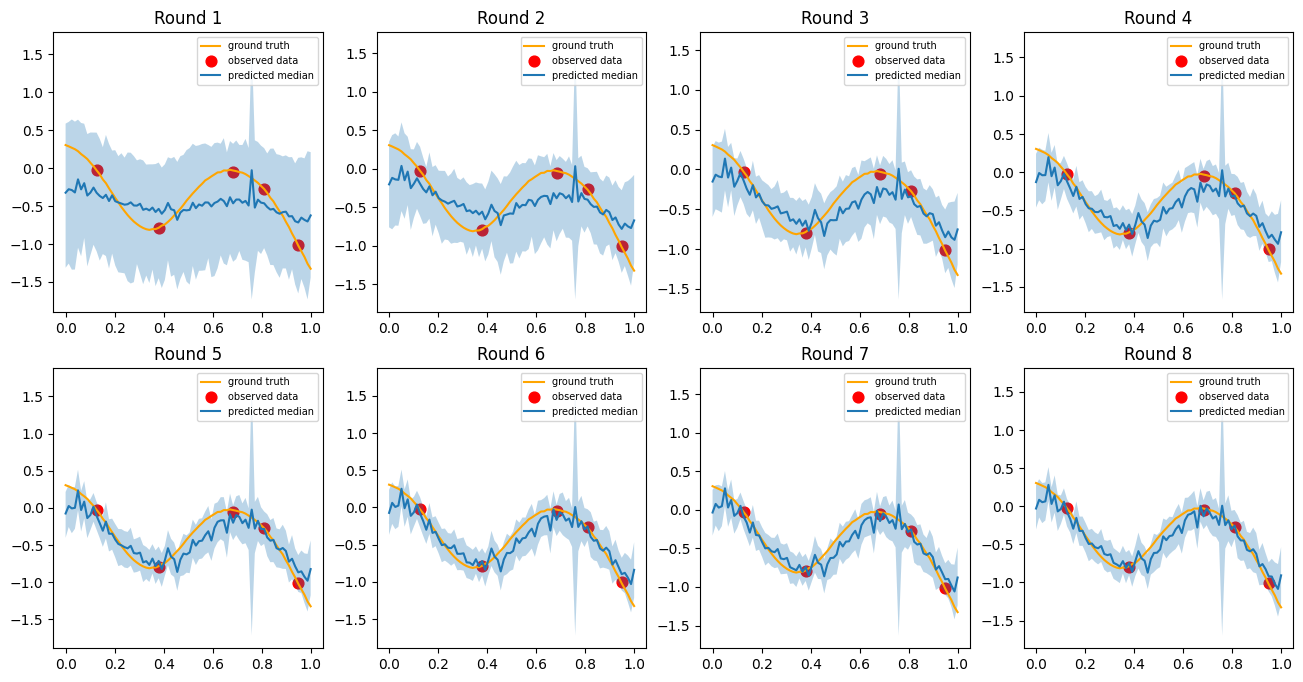

In [ ]:
#@title Put all together : Training and Inference workfow ( Sequential )

input_dim = 80     #  input dimension
condition_dim = 5  #  conditioning dimension (summary statistic dim )
num_layers = 10   # Number of coupling layers

Q=permutation_matrix(input_dim)                                                    # permutation matrix ( orthogonal ) for the permutation layer
model = ConditionalInvertibleNN(input_dim, condition_dim, num_layers,Q).to(device) #instantiate the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)                          # define the optimizer
loss_fn=NLLLoss()
                                                                # instantiate the loss function
#Observed data
y_o=torch.tensor(np.array(y_obs)).unsqueeze(0)
Round=8
fig = plt.figure(figsize=(16,8))

# Start time
proposal=prior         # start with the original proposal (prior)
start_time = time.time()
for i in tqdm(range(1,Round+1)):
  theta,y=simulate_for_sbi(simulator, proposal=proposal, num_simulations=10000)          # simulate synthetic data for training
  train_loss=train_cINN(theta.to(device),y.to(device), model, optimizer,num_epochs=1000) # train
  Learned_posterior=LearnPosterior(y_o,P_z,model,device)                                 # Learned posterior
  fig.add_subplot(2, 4, i)
  plotter(1000,i)                                                                        # visualize posterior predictive
  proposal=Learned_posterior                                                             # use the learned posterior as the prior for the next round
import time
# End time
end_time = time.time()

# Calculate the running time
elapsed_time = end_time - start_time
# Print the running time
print(f"Running time: {elapsed_time:.4f} seconds")

Text(0.5, 1.0, 'GP vs Post predictive')

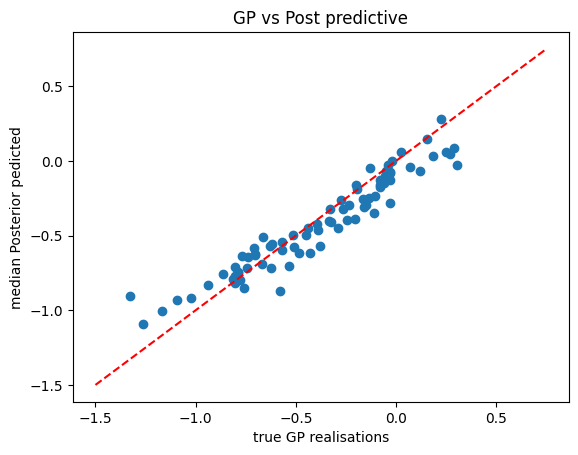

In [ ]:
#@title Ground truth vs posterior predictive
def GP_vs_Pred():
  theta_post, y_pred = simulate_for_sbi(Post_predictive, proposal=Learned_posterior, num_simulations=1000)
  predictions=y_pred.numpy()
  median_post_pred = np.median(predictions, axis=0)
  plt.scatter(gp_draw, median_post_pred)
  plt.plot(np.linspace(-1.5,0.75,10),np.linspace(-1.5,0.75,10),color="red",linestyle='--')
  plt.xlabel("true GP realisations")
  plt.ylabel("median Posterior pedicted")
  plt.title("GP vs Post predictive")

GP_vs_Pred()

In [ ]:
#torch.save(model.state_dict(), 'model_1GP_it8.pth')

In [ ]:
#@title parametrized the base distribution
def build_DM(dim,diag):
  # Create a zero matrix
  D = torch.zeros(dim,dim,device=device)

# Fill  the diagonal with positive values
  for i in range(0, dim):
      D[i, i] = 1/diag[i]
  return D


class ParameterizedBaseDistribution(nn.Module):
    def __init__(self, dim,func):
        super(ParameterizedBaseDistribution, self).__init__()
        self.dim= dim

        # Initialize the lower triangular part (excluding the first diagonal entry) as learnable parameters
        self.mean = nn.Parameter(torch.randn(dim))
        # Initialize the diagonal parameters (excluding the first entry) with positive values
        self.var = nn.Parameter(torch.exp(torch.randn(dim)))
        self.build_dm=func
    def forward(self,z):
      inv_K=self.build_dm(self.dim,self.var)
      log_prob=-0.5 * self.dim * torch.log(torch.tensor(2 * torch.pi))-0.5*torch.einsum('bi,ij,bj->b', z-self.mean, inv_K, z-self.mean)-0.5*torch.sum(torch.log(self.var))
      return log_prob
dim=80
PBase_dist=ParameterizedBaseDistribution(dim,build_DM).to(device)

In [ ]:
#@title prepare for training

def train_cINN(x,cond, model, optimizer, num_epochs):
    train_loss=[]
    model.train()
    for epoch in range(num_epochs):
      #for x, cond in data_loader:

      # Forward pass
      z, log_det_jacobian = model(x, cond)
      log_prob=PBase_dist(z)
      # calculate the loss
      loss=-(log_prob+log_det_jacobian).mean()

      # optimizer zero grad
      optimizer.zero_grad()

      # Backpropagation
      loss.backward()
      # Optimize step
      optimizer.step()
      train_loss.append(loss)
      if epoch % 100==0:
        print(f"Epoch: {epoch} | Loss: {loss}")
    return train_loss

In [ ]:
input_dim = 80     #  input dimension
condition_dim = 5  #  conditioning dimension (summary statistic dim )
num_layers = 10   # Number of coupling layers

Q=permutation_matrix(input_dim)                                                    # permutation matrix ( orthogonal ) for the permutation layer
model = ConditionalInvertibleNN(input_dim, condition_dim, num_layers,Q).to(device) #instantiate the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)                          # define the optimizer

In [ ]:
#@title Learned Posterior
class LearnPosterior(Distribution):
    def __init__(self,y_o,base_dist,model,device):
        super().__init__()
        self.y=y_o # conditioning variable
        self.P_z=base_dist # base distribution
        self.model=model # trained model ( cINN )
        self.device= device # device
    def sample(self,sample_shape=torch.Size()):
        self.model.eval()
        with torch.inference_mode():
          n=sample_shape[0]
          f_post,_=self.model.inverse(self.P_z.sample((n,)).to(self.device),self.y.repeat(n,1).to(self.device))
          if self.device=="cuda":
            f_post=f_post.cpu()
        return f_post


  0%|          | 0/8 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 234.2804412841797
Epoch: 100 | Loss: -253.53602600097656
Epoch: 200 | Loss: -331.859130859375
Epoch: 300 | Loss: -365.81134033203125
Epoch: 400 | Loss: -382.3466796875
Epoch: 500 | Loss: -402.470703125
Epoch: 600 | Loss: -408.7691955566406
Epoch: 700 | Loss: -423.2934875488281
Epoch: 800 | Loss: -435.8538513183594
Epoch: 900 | Loss: -429.118896484375


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.LearnPosterior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:40<04:45, 40.84s/it]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: -413.8133850097656
Epoch: 100 | Loss: -469.5943908691406
Epoch: 200 | Loss: -473.2268981933594
Epoch: 300 | Loss: -446.2281799316406
Epoch: 400 | Loss: -476.4889831542969
Epoch: 500 | Loss: -470.0392761230469
Epoch: 600 | Loss: -478.602783203125
Epoch: 700 | Loss: -478.8208312988281
Epoch: 800 | Loss: -478.1344909667969
Epoch: 900 | Loss: -481.3708801269531


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [01:17<03:49, 38.33s/it]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: -489.87359619140625
Epoch: 100 | Loss: -494.61865234375
Epoch: 200 | Loss: -500.1643981933594
Epoch: 300 | Loss: -501.706787109375
Epoch: 400 | Loss: -505.493896484375
Epoch: 500 | Loss: -503.4701843261719
Epoch: 600 | Loss: -507.6794738769531
Epoch: 700 | Loss: -505.6429748535156
Epoch: 800 | Loss: -505.4552917480469
Epoch: 900 | Loss: -505.40167236328125


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [01:54<03:07, 37.56s/it]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: -518.9964599609375
Epoch: 100 | Loss: -516.3019409179688
Epoch: 200 | Loss: -520.6837768554688
Epoch: 300 | Loss: -523.317138671875
Epoch: 400 | Loss: -516.1633911132812
Epoch: 500 | Loss: -525.0745849609375
Epoch: 600 | Loss: -522.3643798828125
Epoch: 700 | Loss: -520.4086303710938
Epoch: 800 | Loss: -526.664794921875
Epoch: 900 | Loss: -524.2315673828125


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 50%|█████     | 4/8 [02:30<02:28, 37.18s/it]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: -532.8404541015625
Epoch: 100 | Loss: -531.5211181640625
Epoch: 200 | Loss: -535.5899047851562
Epoch: 300 | Loss: -536.0404663085938
Epoch: 400 | Loss: -535.166259765625
Epoch: 500 | Loss: -536.2897338867188
Epoch: 600 | Loss: -539.352783203125
Epoch: 700 | Loss: -539.0986938476562
Epoch: 800 | Loss: -538.5061645507812
Epoch: 900 | Loss: -537.00048828125


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [03:07<01:51, 37.06s/it]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: -544.1585083007812
Epoch: 100 | Loss: -542.0140991210938
Epoch: 200 | Loss: -547.4568481445312
Epoch: 300 | Loss: -546.8604125976562
Epoch: 400 | Loss: -545.6675415039062
Epoch: 500 | Loss: -546.6614990234375
Epoch: 600 | Loss: -548.6709594726562
Epoch: 700 | Loss: -547.4569702148438
Epoch: 800 | Loss: -549.447998046875
Epoch: 900 | Loss: -549.0100708007812


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [03:44<01:14, 37.01s/it]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: -553.1163940429688
Epoch: 100 | Loss: -547.5825805664062
Epoch: 200 | Loss: -550.7380981445312
Epoch: 300 | Loss: -552.56298828125
Epoch: 400 | Loss: -555.8023071289062
Epoch: 500 | Loss: -555.9334106445312
Epoch: 600 | Loss: -554.0235595703125
Epoch: 700 | Loss: -556.2454833984375
Epoch: 800 | Loss: -557.42578125
Epoch: 900 | Loss: -557.724609375


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [04:21<00:36, 36.98s/it]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 0 | Loss: -560.877685546875
Epoch: 100 | Loss: -553.11279296875
Epoch: 200 | Loss: -539.6232299804688
Epoch: 300 | Loss: -540.38818359375
Epoch: 400 | Loss: -562.0491943359375
Epoch: 500 | Loss: -560.0191040039062
Epoch: 600 | Loss: -560.7273559570312
Epoch: 700 | Loss: -561.1512451171875
Epoch: 800 | Loss: -563.3742065429688
Epoch: 900 | Loss: -563.9041137695312


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 8/8 [04:57<00:00, 37.24s/it]


Running time: 297.9588 seconds


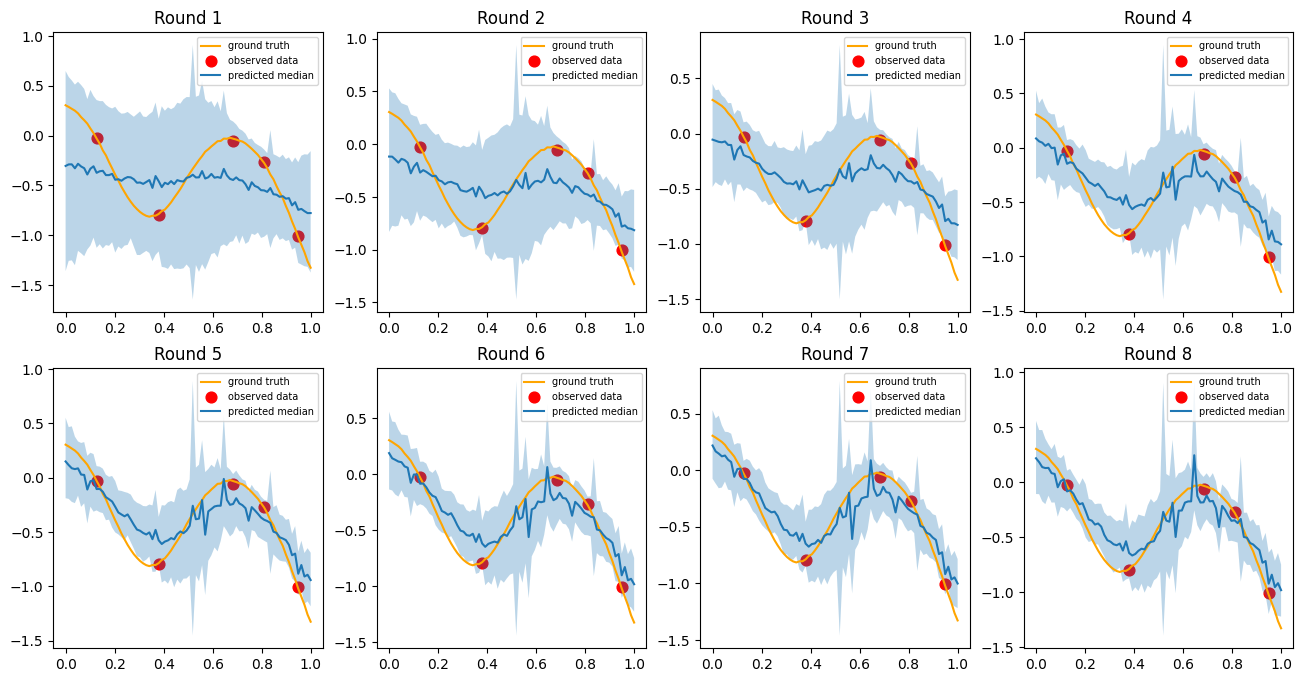

In [ ]:
#@title Training & Inference workflow with the "learned base distribution" ( Sequential )
input_dim = 80     #  input dimension
condition_dim = 5  #  conditioning dimension (summary statistic dim )
num_layers = 10    # Number of coupling layers

Q=permutation_matrix(input_dim)                                                    # permutation matrix ( orthogonal ) for the permutation layer
model = ConditionalInvertibleNN(input_dim, condition_dim, num_layers,Q).to(device) #instantiate the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)                          # define the optimizer

#Observed data
y_o=torch.tensor(np.array(y_obs)).unsqueeze(0)
Round=8
fig = plt.figure(figsize=(16,8))

# Start time
proposal=prior         # start with the original proposal (prior)
start_time = time.time()
for i in tqdm(range(1,Round+1)):
  theta,y=simulate_for_sbi(model_simulator, proposal=proposal, num_simulations=5000)          # simulate synthetic data for training
  train_loss=train_cINN(theta.to(device),y.to(device), model, optimizer,num_epochs=1000) # train
  learned_mean=PBase_dist.state_dict()['mean']
  learned_Cov=torch.diag(PBase_dist.state_dict()['var'])
  P_z =dist.MultivariateNormal(learned_mean,learned_Cov)                                 # Learned base_distribution
  Learned_posterior=LearnPosterior(y_o,P_z,model,device)                                 # Learned posterior
  fig.add_subplot(2, 4, i)
  plotter(1000,i)                                                                        # visualize posterior predictive
  proposal=Learned_posterior                                                             # use the learned posterior as the prior for the next round
import time
# End time
end_time = time.time()

# Calculate the running time
elapsed_time = end_time - start_time

# Print the running time
print(f"Running time: {elapsed_time:.4f} seconds")

In [ ]:
#@title plotter function
def plotter2(n_samples,i=1):
  x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_datapoint"])
  theta_post, y_pred = simulate_for_sbi(Post_predictive, proposal=Learned_posterior, num_simulations=n_samples)
  predictions=theta_post.numpy()
  median_post_pred = np.median(predictions, axis=0)
  hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


  plt.plot(x, gp_draw, label="ground truth", color="orange")
  plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
  plt.plot(x, median_post_pred, label="predicted median")
  plt.title(f'Round {i}')
  plt.legend(fontsize=7)
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 90% BCI")

#2nd Approach: Graphical Models + Transformer + Diffusion model



\begin{equation}
\theta\sim p(\theta)\\
f\mid \theta\sim
GP(\mu,\Sigma(\theta) )\\
\eta=X\beta +f\\
y\mid \eta \sim p(u^{-1}(\eta),\theta)
\end{equation}

$\theta=\{l,\sigma\}$

$

In [ ]:
#@title Likelihood (simulator ) and Prior ( Gaussian Process ) over parameters  (80 params).
class CustomPrior(Distribution):
    def __init__(self, low, high,cov_func):
        super().__init__()
        self.dist1 = dist.Uniform(low=low, high=high) # prior over lenghtscale
        #self.dist2 = dist.HalfNormal(scale)
        self.cov_func = cov_func  # Function to compute covariance matrix

    def sample(self, sample_shape=torch.Size()):
        sample1 = self.dist1.sample(sample_shape) # ls
        #sample2 = self.dist2.sample(sample_shape) # epsilon
        # Calculate covariance matrix using the sample from dist1
        if sample1.dim()==0:
          K= self.cov_func(ls=sample1)
          dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          sample3=dist3.sample()
          samples=sample3
        else:
          sample_list=[]
          for ls in sample1:
            K= self.cov_func(ls=ls)   #GP_kernel
            # Create dist3 using the calculated covariance matrix
            dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          # Sample from dist3
            sample_list.append(dist3.sample())
          # combine sample
          sample3= torch.stack(sample_list)

            # Concatenate sample1, sample2, and sample3 along the last dimension
          samples = sample3
        return samples

    def log_prob(self):
        pass

### define the prior and the Model simulator model
## Prior
prior=CustomPrior(low=0.01, high=1, cov_func=gp_kernel)                 # GP priors with RBF kernel

## Martern prior
K = matern_kernel(ls=length_scale)
mean = torch.zeros(80)  # Zero mean
prior2= MultivariateNormal(mean, covariance_matrix=cov_matrix)


## Likelihood
def likelihood(theta):
  epsilon=dist.HalfNormal(0.1).sample()
  if theta.dim()==1:
    f_gp=theta                             #[np.array(obs_idx)]
  else:
    f_gp=(theta[:,:]).squeeze()             #np.array(obs_idx)

  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))
  y=dist.MultivariateNormal(mean,cov).sample()
  # y= f_gp + epsilon*torch.randn_like(f_gp)
  return y.unsqueeze(0)


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [ ]:
#@title  choose indices ( location unit ) of data points for inference ( observations )
obs_idx_lst = [np.array([10,23, 40, 61,75]),np.array([11,23, 39,50,61,72]),np.array([ 2, 11, 19, 27, 35, 43, 51, 59, 67, 75]),np.array([ 2, 12, 22, 32, 42, 52, 62, 72])]
#obs_idx_lst.append( ) # Add a set of indices

obs_idx1 = obs_idx_lst[0]   # indices use for the 1st model
obs_idx2 = obs_idx_lst[1]   # indices use for the 2nd model
obs_idx3 = obs_idx_lst[2]   # indices use for the 3rd model
obs_idx5 = obs_idx_lst[3]   # indices use for the 4th (RBF)/5rd model (Martern kernel)
x_obs = x[np.array(obs_idx5)]

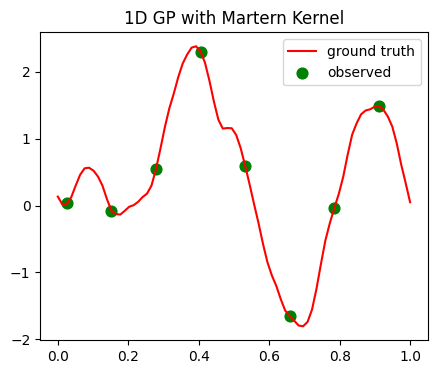

In [ ]:
#@title GP  Priors with Martern kernel
torch.manual_seed(60)
p=prior2.sample()
y_true=p
def play_simul(prior,simulator):
  plt.figure(figsize=(5,4))
  y_obs=simulator(prior).squeeze().numpy()
  plt.plot(x.numpy(),prior.numpy(),label="ground truth", color="red")
  plt.scatter(x_obs,y_obs[obs_idx5], color="green", label="observed", s=60)
  plt.title("1D GP with Martern Kernel")
  plt.legend()
  plt.show()
  return y_obs[obs_idx1], y_obs[obs_idx2],y_obs[obs_idx3],y_obs[obs_idx5]

y_obs1,y_obs2,y_obs3,y_obs5= play_simul(p,likelihood)

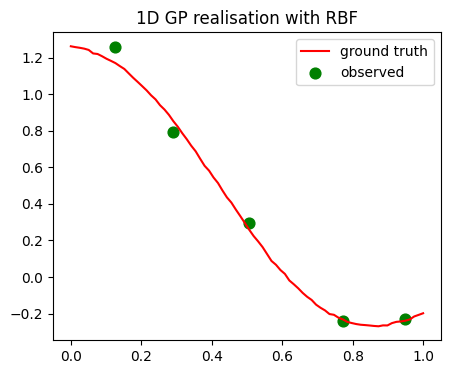

In [ ]:
#@title  Synthetic ground truth & Observation
#@title  choose indices ( location unit ) of data points for inference ( observations )

torch.manual_seed(4)          #4 ,16, 22,23,29,38,40 (best),45(best),47( more fluc),54,68,72
p=prior.sample()
y_true=p
def play_simul(prior,simulator):
  plt.figure(figsize=(5,4))
  y_obs=simulator(prior).squeeze().numpy()
  plt.plot(x.numpy(),prior.numpy(),label="ground truth", color="red")
  plt.scatter(x[np.array(obs_idx1)],y_obs[obs_idx1], color="green", label="observed", s=60)
  plt.title("1D GP realisation with RBF")
  plt.legend()
  plt.show()
  return y_obs[obs_idx1], y_obs[obs_idx2],y_obs[obs_idx5] #y_obs[obs_idx3],

y_obs1,y_obs2,y_obs5= play_simul(p,likelihood)                       # Observed data points (different set location )

In [ ]:
jax.devices()

[cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]

In [ ]:
# Set random key
key = jax.random.PRNGKey(3)

In [ ]:
#key = jax.random.PRNGKey(40)

In [ ]:
#@title Simulate synthetic data for training ( 20000 simulated samples).
theta, _ = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=20000) # theta== Gaussian Process sample, y= likelihood sample

#
data=jnp.array((np.array(theta.unsqueeze(-1))))
nodes_max = data.shape[1]                       # each variable is consider a node of a graph
node_ids = jnp.arange(nodes_max)                # node Id ( position )
print(f'data shape:{data.shape}')               # (Batch_dim, node_max ,1)

Running 20000 simulations.:   0%|          | 0/20000 [00:00<?, ?it/s]

data shape:(20000, 80, 1)


In [ ]:
#@title 2) Setting up the diffusion process
# VESDE
T = 1.
T_min = 1e-2
sigma_min = 1e-3
sigma_max = 15.

p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)

# Scaling fn for the output of the score model
def output_scale_fn(t, x):
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    return (1/scale * x).reshape(x.shape)

### 3) Building the Architecture:

Two main components:

* **Tokenizer**:
This component jointly embeds 'x', 'node_ids', and the 'condition_mask' into a unified
vector known as a token.
    * **Value Embedding**: Embeds the value of the variable.
    * **Node Embedding**: Embeds the node ID.
    * **Condition Embedding**: Embeds the condition mask.
* **Transformer**: This is a transformer model that takes tokens as input and generates scores for each node.
    * **Num_heads**: Specifies the number of heads in the multi-head attention mechanism.
    * **Attn_size**: Determines the size of attention, i.e., the dimensions to which query and key are projected.
    * **Num_layers**: Sets the number of layers in the transformer.
    * **Widening_factor**: Specifies the factor by which the hidden size of the MLP is increased in each layer.

 we construct a compact Simformer with 2 layers and 2 heads.


In [ ]:
#@title build the Embedding modules + Transformer architecture

#setup the latent dimensions
dim_value = 20      # Size of the value embedding
dim_id = 20         # Size of the node id embedding
dim_condition = 10  # Size of the condition embedding


def model(t: Array, x: Array, node_ids: Array, condition_mask:Array, edge_mask: Optional[Array]=None):
    """Simplified Simformer model.

    Args:
        t (Array): Diffusion time
        x (Array): Value of the nodes
        node_ids (Array): Id of the nodes
        condition_mask (Array): Condition state of the nodes
        edge_mask (Array, optional): Edge mask. Defaults to None.
    Returns:
        Array: Score estimate of p(x_t)
    """

    batch_size, seq_len, _ = x.shape
    condition_mask = condition_mask.astype(jnp.bool_).reshape(-1,seq_len, 1)
    node_ids = node_ids.reshape(-1,seq_len)
    t = t.reshape(-1,1, 1)

    # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
    embedding_time = GaussianFourierEmbedding(64)  # Time embedding method
    time_embeddings = embedding_time(t)

    # Tokinization part --------------------------------------------------------------------------------

    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)    # Value embedding net ( we just repeat the value)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))   # Node id embedding nets (we use a learnable random embedding vector)
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.5)) #Condition embedding (here we use a learnable random embedding vector)
    condition_embedding = condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding vector
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))

    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)

    # Concatenate embeddings (alternatively we can also add instead of concatenating)
    x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)

    # Transformer part --------------------------------------------------------------------------------
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3)

    # Encode -  use a transformer to transform the tokenized inputs into a latent representation
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)

    # Decode - here we just use a linear layer to get the score estimate (we scale the output by the marginal std dev)
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out) # SDE dependent output scaling
    return out

In [ ]:
# import pickle
# # load model params
# with open("/content/tree_params_GP_inf_best_10points_Martkernel.pkl", 'rb') as file:
#      params_2= pickle.load(file)


In [ ]:
#@title  Initialize the model .( as require in Haiku )
# Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument)

init, model_fn= hk.without_apply_rng(hk.transform(model))
params=init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))

# view total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

Total number of parameters:  47314


{'embed': {'embeddings': (80, 20)},
 'gaussian_fourier_embedding': {'B': (33, 1)},
 'linear': {'b': (1,), 'w': (50, 1)},
 'transformer/layer_norm': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_1': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_2': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_3': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_4': {'offset': (50,), 'scale': (50,)},
 'transformer/linear': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_1': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_2': {'b': (50,), 'w': (64, 50)},
 'transformer/linear_3': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_4': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_5': {'b': (50,), 'w': (64, 50)},
 'transformer/multi_head_attention/key': {'b': (20,), 'w': (50, 20)},
 'transformer/multi_head_attention/linear': {'b': (50,), 'w': (20, 50)},
 'transformer/multi_head_attention/query': {'b': (20,), 'w': (50, 20)},
 'transformer/mult

In [ ]:
N=80 #dimentionality

In [ ]:
#@title  The loss function
def weight_fn(t:Array):
    # MLE weighting
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

def loss_fn(params: dict, key: PRNGKey,batch_size:int= 1024):

    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)

    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generator(rng_data, batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids

    # # Condition mask -> randomly condition on some data.
    #condition_mask = jax.random.bernoulli(rng_condition, 0.10, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    # condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    # condition_mask *= condition_mask_all_one # Avoid conditioning on all nodes -> nothing to train...
    #condition_mask = condition_mask[..., None]

    #Alternatively  set the condition mask manually to specific conditional distributions.
    #cond= jnp.zeros((80,), dtype=jnp.bool_)  # Joint mask
    cond=jnp.zeros((N),dtype=jnp.bool_).at[obs_idx].set(1) # Posterior mask
    condition_mask= jnp.tile(jnp.expand_dims(cond,axis=0), (batch_xs.shape[0], 1))  # Replicate along the first dimension

    # one can also structure the base mask!
    #edge_mask = jnp.ones((4*batch_size//5, batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.bool_) # Dense default mask

    # Optional: Include marginal consistency
    # marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    # edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    # edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask) #, edge_mask=edge_masks
    return loss

In [ ]:
#@title training : designed  to leverage parallel computation on multiple devices  ( GPU )
optimizer = optax.adam(1e-3)        # optimizer
opt_state = optimizer.init(params_2)  # initial params state

@partial(jax.pmap, axis_name="num_devices")                                 # parallelize computations
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)                  # compute loss and gradients

    loss = jax.lax.pmean(loss, axis_name="num_devices")                     # aggregate loss accross devices ( mean )
    grads = jax.lax.pmean(grads, axis_name="num_devices")                   # aggregate gradients accross devices ( mean )

    updates, opt_state = optimizer.update(grads, opt_state, params=params)  #
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state


In [ ]:
#title replicate the model params and optimizer state across available devices for data-parallel computation
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params_2)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

In [ ]:
#check avaible devices
print("Devices:", jax.devices())

Devices: [cuda(id=0), cuda(id=1)]


In [ ]:
#@title define data generator:
def generator(key: PRNGKey, n:int):
    key1,key2= jrandom.split(key,2)
    theta, y = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=n)
    return jnp.array((np.array(theta.unsqueeze(-1))))

In [ ]:
#training loop
start_time=time.time()
key = jrandom.PRNGKey(2)
train_loss=[]
epochs=2
for epoch in range(epochs):
    l = 0
    for i in range(5000):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey,  (n_devices,)), replicated_opt_state)
        l += loss[0] /5000
    train_loss.append(l)
    #if epoch % 10==0:
    print(f"Epoch: {epoch} | Loss: {l}")
end_time=time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.4f} seconds")

#get updated params (tree object ) for inference
params_2= jax.tree_map(lambda x: x[0], replicated_params)

Running 1024 simulations.:   0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Epoch: 0 | Loss: 664.3549194335938
Epoch: 1 | Loss: 656.5897216796875
Running time: 366.1182 seconds


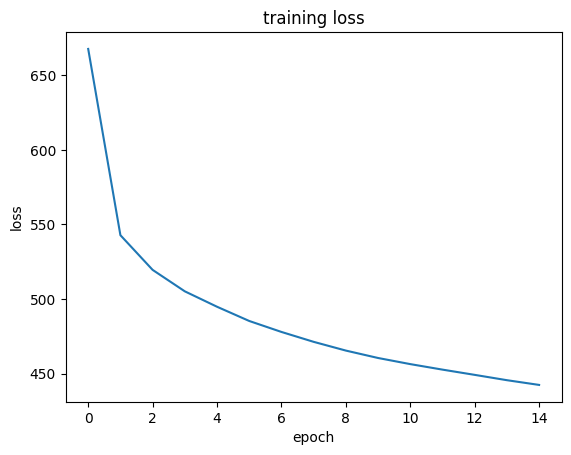

In [ ]:
def training_history(train_loss):
  plt.plot(np.arange(len(train_loss)),np.array(train_loss))
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("training loss")

training_history(train_loss)

In [ ]:
# # # Save the tree object (params) to a file
# import pickle
# with open('tree_params_GP_50pts_2D_maternkernel.pkl', 'wb') as f:
#       pickle.dump(params, f)

In [ ]:
#@title Sampling  process

from functools import partial
from probjax.utils.sdeint import sdeint

condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))

# Reverse SDE drift
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])

    return f

# Reverse SDE diffusion
def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x)
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]

    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys

In [ ]:
#@title .
## 1st model: 5 observed points
# Reverse SDE drift
def drift_backward_1(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params_1, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])

    return f

# Reverse SDE diffusion
def diffusion_backward_1(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x)
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn_1(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]

    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward_1(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward_1(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys


## models2 6 observed points
def drift_backward_2(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params_2, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])

    return f

# Reverse SDE diffusion
def diffusion_backward_2(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x)
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn_2(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]

    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward_2(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward_2(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys


In [ ]:
#@title plotting function

def mean_pred(samples,y_true,x_obs,y_obs):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.mean(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


  plt.plot(x, np.array(y_true), label="ground truth", color="orange")
  plt.scatter(x_obs, np.array(y_obs), color="red", label="observed ", s=60)
  plt.plot(x, mean_post_pred, label="predicted mean")
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")
  plt.legend(fontsize=6)

def median_pred(samples,y_true,x_obs,y_obs,title="inferred mean",labels=False):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
  plt.plot(x, np.array(y_true), label="ground truth", color="orange")
  plt.scatter(x_obs, np.array(y_obs), color="red", label="observed", s=40)
  plt.plot(x, mean_post_pred, label="predicted mean")
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")
  plt.xlim([0, 1])
  #plt.xticks([])  # Removes x-axis ticks
  plt.yticks([])  # Removes y-axis ticks
  plt.title(title)
  plt.xlabel('x')
  if labels==True:
      plt.yticks()
      plt.ylabel('f(x)')
  #plt.legend()
  plt.tight_layout()  # Adjust layout to fit everything nicely
  plt.legend(fontsize=7)

In [ ]:
n=10

In [ ]:
def median_pred(samples,y_true,x_obs,y_obs,title=None,labels=False,draws=False):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
  plt.plot(x, np.array(y_true), label="ground truth (RBF)", color="orange")
  plt.scatter(x_obs, np.array(y_obs), color="red", label="observed", s=40)
  plt.plot(x, mean_post_pred, label="predicted mean",alpha=1)
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=0.5, interpolate=True, label="posterior: 95% BCI")
  if draws==True:
        # Randomly select 'n' row vectors and plot them
    selected_indices = np.random.choice(predictions.shape[0], n, replace=False)
    for i, idx in enumerate(selected_indices):
        if i == 0:
              # Add label only for the first line
            plt.plot(x, predictions[idx], color='green', alpha=0.3, label="Posterior draws")
        else:
              # No label for the remaining lines
            plt.plot(x, predictions[idx], color='green', alpha=0.3)

  plt.xlim([0, 1])
  #plt.xticks([])  # Removes x-axis ticks
  plt.yticks([])  # Removes y-axis ticks
  if title!=None:
    plt.title(title)
  if labels==True:
      plt.xlabel('x')
      plt.ylabel('f(x)')
  #plt.legend()
  plt.tight_layout()  # Adjust layout to fit everything nicely
  plt.legend(fontsize=7)


In [ ]:
#@title Full conditional estimation : Inference

def Inference(obs_idx,y_obs,y_true,n_samples=100,title=None,labels=False,draws=False):
    start_time = time.time()
    cond_stat=jnp.zeros((80),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeting the posterior
    y=jnp.zeros((80)).at[obs_idx].set(y_obs) # observed values ( conditioned )
    samples = sample_fn(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
    sample_theta=samples[...,-1,:]
    #mean_pred(sample_theta,y_true,x[obs_idx],y_obs)
    median_pred(sample_theta,y_true,x[obs_idx],y_obs,title=title,labels=labels,draws=draws)
    end_time = time.time()
    # Calculate the running time
    elapsed_time = end_time - start_time
    print(" ")
    print(f"inference time: {elapsed_time} sec , for {n_samples} samples")

In [ ]:
Inference()

In [ ]:
#@title .
#  Posterior inference
def Inference_1(obs_idx,y_obs,y_true,n_samples=100,title=None,labels=False,draws=False):
    start_time = time.time()
    cond_stat=jnp.zeros((80),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeting the posterior
    y=jnp.zeros((80)).at[obs_idx].set(y_obs) # observed values ( conditioned )
    samples = sample_fn_1(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
    sample_theta=samples[...,-1,:]
    #mean_pred(sample_theta,y_true,x[obs_idx],y_obs)
    median_pred(sample_theta,y_true,x[obs_idx],y_obs,title=title,labels=labels,draws=draws)
    end_time = time.time()
    # Calculate the running time
    elapsed_time = end_time - start_time
    # print(" ")
    # print(f"inference time: {elapsed_time} sec , for {n_samples} samples")

def Inference_2(obs_idx,y_obs,y_true,n_samples=100,title=None,labels=False,draws=False):
    start_time = time.time()
    cond_stat=jnp.zeros((80),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeting the posterior
    y=jnp.zeros((80)).at[obs_idx].set(y_obs) # observed values ( conditioned )
    samples = sample_fn_2(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
    sample_theta=samples[...,-1,:]
    #mean_pred(sample_theta,y_true,x[obs_idx],y_obs)
    median_pred(sample_theta,y_true,x[obs_idx],y_obs,title=title,labels=labels,draws=draws)
    end_time = time.time()
    # Calculate the running time
    elapsed_time = end_time - start_time
    # print(" ")
    # print(f"inference time: {elapsed_time} sec , for {n_samples} samples")

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


 
inference time: 32.302459478378296 sec , for 5000 samples


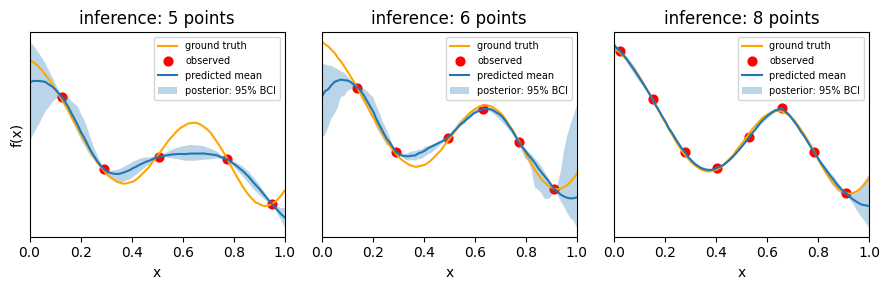

In [ ]:
#y_1
fig = plt.figure(figsize=(9,3))
fig.add_subplot(1,3,1)
Inference_1(obs_idx1,y_obs1,y_true,title="inference: 5 points",labels=True)
fig.add_subplot(1,3,2)
Inference_2(obs_idx2,y_obs2,y_true,title="inference: 6 points",labels=False)
fig.add_subplot(1,3,3)
Inference(obs_idx5,y_obs5,y_true,title="inference: 8 points",labels=False)


In [ ]:
y_obs=[]

In [ ]:
def pict():
  fig = plt.figure(figsize=(10,4))
  y_true,y_obs1,y_obs2,y_obs5=y_obs[0]
  fig.add_subplot(2,3,1)
  Inference_1(obs_idx1,y_obs1,y_true,title="inference (RBF): 5 points",labels=True)
  fig.add_subplot(2,3,2)
  Inference_2(obs_idx2,y_obs2,y_true,title="inference (RBF): 6 points",labels=False)
  fig.add_subplot(2,3,3)
  Inference(obs_idx5,y_obs5,y_true,title="inference (RBF): 8 points",labels=False)

  y_true,y_obs1,y_obs2,y_obs5=y_obs[1]

  fig.add_subplot(2,3,4)
  Inference_1(obs_idx1,y_obs1,y_true,labels=True,draws=True)
  fig.add_subplot(2,3,5)
  Inference_2(obs_idx2,y_obs2,y_true,labels=False,draws=True)
  fig.add_subplot(2,3,6)
  Inference(obs_idx5,y_obs5,y_true,labels=False,draws=True)
  return fig


 
inference time: 33.19503307342529 sec , for 5000 samples
 
inference time: 33.20668125152588 sec , for 5000 samples


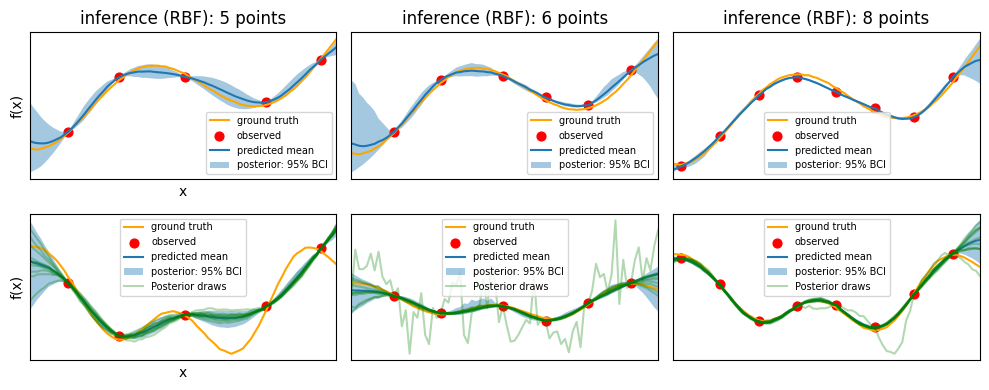

In [ ]:
fig=pict()

In [ ]:
fig.savefig('Simfor_1D_exp2_fig2.svg')   # Save as PNG
fig.savefig('Simfor_1D_exp2_fig2.pdf')

In [ ]:
#y_obs.append((y_true,y_obs3))
def pict2():
  fig = plt.figure(figsize=(10,4))
  for i, (y_true,y_obs3) in enumerate(y_obs):
    fig.add_subplot(1,3,i+1)
    Inference_2(obs_idx3,y_obs3,y_true,title=f'Inferred GP with Matérn Kernel: exp {i+1}',labels=True,draws=False,n_samples=5000)
  return fig


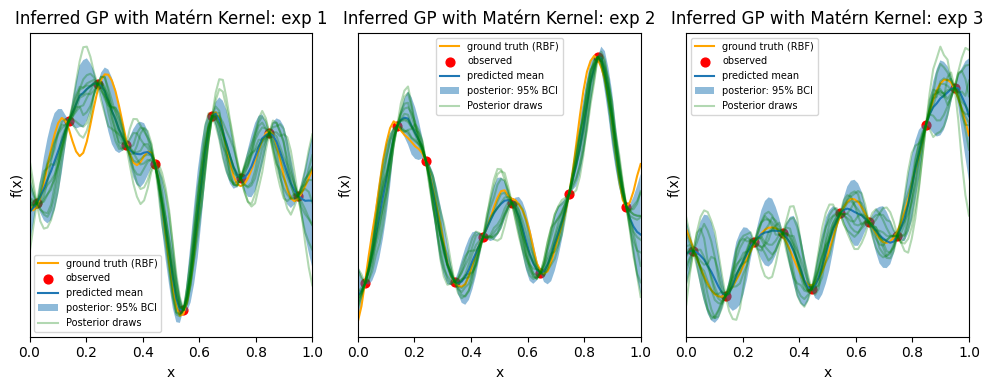

In [ ]:
fig1=pict2()

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


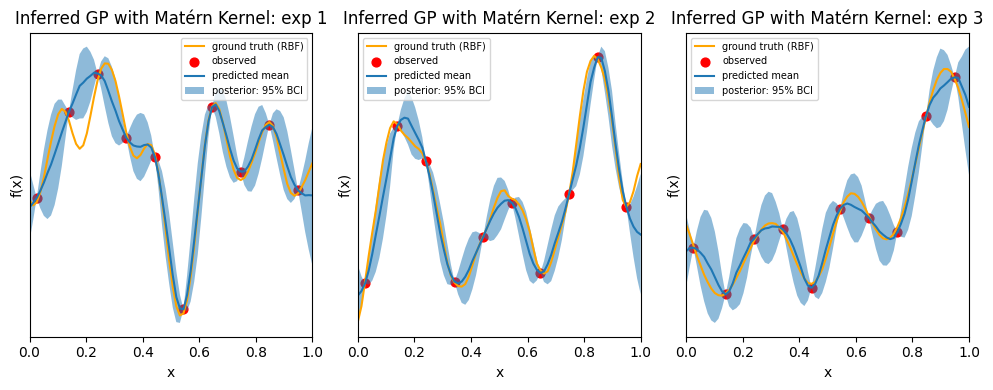

In [ ]:
fig1=pict2()

In [ ]:
# fig1.savefig('Simfor_1D_exp3_Matern_kernel_fig2.svg')
# fig1.savefig('Simfor_1D_exp3_Matern_kernel_fig2.pdf')

In [ ]:
# with open('/content/ref.pkl', 'rb') as file:
#     y_1= pickle.load(file)

 
inference time: 62.00708270072937 sec , for 10000 samples


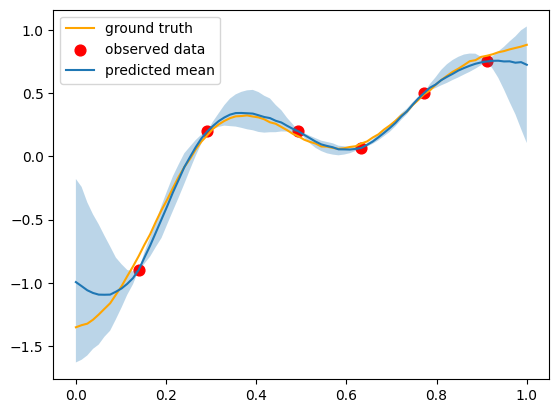

In [ ]:
Inference()

# 2D Gaussian Process Inference ( with Matern Kernel )

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal


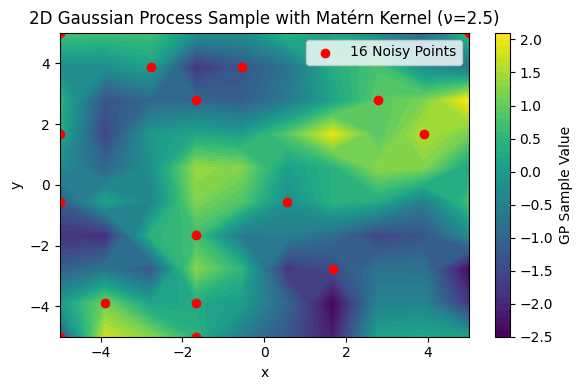

Indices of the 16 points (with noise) in the flattened grid: tensor([54, 77, 48,  4, 37, 99, 11,  0, 28, 30,  9, 62,  6, 31, 86, 33])


In [ ]:
# Step 1: Generate 2D grid of points
N = 10  # Number of points along each dimension
x = torch.linspace(-5, 5, N)
y = torch.linspace(-5, 5, N)
X_grid, Y_grid = torch.meshgrid(x, y)
X = torch.stack([X_grid.flatten(), Y_grid.flatten()], dim=1)  # Shape (N^2, 2)

# Function for Matérn Kernel
def matern_kernel(ls=0.8, X=X, X_prime=X, nu=2.5,variance=1,jitter=1.0e-6):
    # Implementation for Matern Kernel (ν=2.5)
    dist = torch.cdist(X, X_prime, p=2) / ls
    sqrt_5_dist = torch.sqrt(torch.tensor(5.0)) * dist
    kernel = variance * (1 + sqrt_5_dist + (5.0/3.0) * dist**2) * torch.exp(-sqrt_5_dist)
    return kernel + jitter * torch.eye(kernel.shape[0])


torch.manual_seed(6)  # 6 (16 obs points)

# Step 2: Compute the covariance matrix using the Matérn kernel
nu = 2.5  # Smoothness parameter
length_scale = 1.0  # Length scale
variance = 1.0  # Variance
cov_matrix = matern_kernel(ls=length_scale, X=X, X_prime=X, nu=nu, variance=variance)

# Step 3: Generate GP samples (mean zero, covariance from Matérn kernel)
mean = torch.zeros(N * N)  # Zero mean for each point in the 2D space
gp = MultivariateNormal(mean, covariance_matrix=cov_matrix)

# Sample from the GP
samples = gp.sample((1,)).reshape(N, N)  # Generate 1 sample and reshape to 2D grid


# Step 4: Select 16 random points from the sample grid and add noise to their values

selected_16 = torch.randperm(N * N)[:16]  # Indices of 16 random points
noise = torch.randn(16) * 0.1  # Add noise to the sample values
noisy_samples = samples.flatten()  # Flatten the sample grid
noisy_samples[selected_16] += noise  # Add noise to the selected points


# Step 6: Plot the GP sample with the noisy points and the 8 random points
plt.figure(figsize=(6, 4))  # Increase figure size for better fitting
plt.contourf(X_grid.numpy(), Y_grid.numpy(), samples.numpy(), cmap='viridis', levels=50)
plt.colorbar(label='GP Sample Value')

# Mark noisy points on the grid
points_16 = X[selected_16]
plt.scatter(points_16[:, 0], points_16[:, 1], color='r', label='16 Noisy Points', marker='o')

# Ensure the plot fits the map
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title('2D Gaussian Process Sample with Matérn Kernel (ν=2.5)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


# Print the saved indices of the selected points
print(f"Indices of the 16 points (with noise) in the flattened grid: {selected_16}")



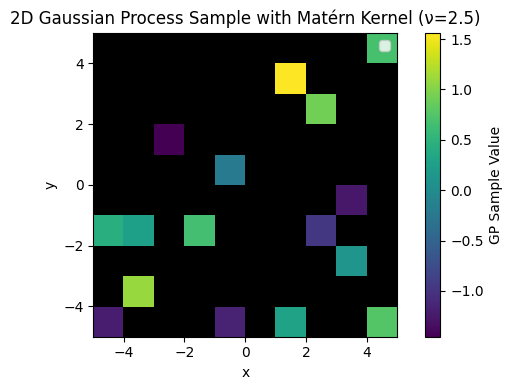

In [ ]:
# Step 3: Create a mask for non-selected locations
mask = np.ones_like(samples.numpy(), dtype=bool)  # Initialize mask as True (all points masked)
mask = mask.flatten()  # Flatten the mask
mask[selected_16.numpy()] = False  # Unmask selected points
masked_samples = np.ma.array(samples.numpy(), mask=mask.reshape(N, N))  # Mask the non-selected points

# Step 4: Plot the masked GP sample using imshow
plt.figure(figsize=(6, 4))  # Increase figure size for better fitting

# Create a colormap and set the color for masked values (black)
cmap = plt.cm.viridis
cmap.set_bad(color='black')  # Set color for masked values

# Use imshow to plot, with masked values in black
plt.imshow(masked_samples, cmap=cmap, extent=(-5, 5, -5, 5), origin='lower')
plt.colorbar(label='GP Sample Value')
# Customize plot appearance
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.title('2D Gaussian Process Sample with Matérn Kernel (ν=2.5)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [ ]:
x_obs1=x_obs
id1=obs_idx


In [ ]:
obs_idx=selected_16.numpy()
x_obs=points_16.numpy()
y_obs=noisy_samples[obs_idx].numpy()

In [ ]:
#@title Likelihood (simulator ) and Prior ( Gaussian Process )
class CustomPrior(Distribution):
    def __init__(self, low, high,cov_func):
        super().__init__()
        self.dist1 = dist.Uniform(low=low, high=high) # prior over lenghtscale
        #self.dist2 = dist.HalfNormal(scale)
        self.cov_func = cov_func  # Function to compute covariance matrix

    def sample(self, sample_shape=torch.Size()):
        sample1 = self.dist1.sample(sample_shape) # ls
        #sample2 = self.dist2.sample(sample_shape) # epsilon
        # Calculate covariance matrix using the sample from dist1
        if sample1.dim()==0:
          K= self.cov_func(variance=sample1)
          dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          sample3=dist3.sample()
          samples=sample3
        else:
          sample_list=[]
          for var in sample1:
            K= self.cov_func(variance=var)   #GP_kernel
            # Create dist3 using the calculated covariance matrix
            dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          # Sample from dist3
            sample_list.append(dist3.sample())
          # combine sample
          sample3= torch.stack(sample_list)

            # Concatenate sample1, sample2, and sample3 along the last dimension
          samples = sample3
        return samples

    def log_prob(self):
        pass

### define the prior and the Model simulator model
## Prior
prior=CustomPrior(low=0.1, high=1, cov_func=matern_kernel)                 # GP priors with RBF kernel

## Martern prior
K = matern_kernel(ls=0.8)
mean = torch.zeros(N*N)  # Zero mean
prior2= MultivariateNormal(mean, covariance_matrix=cov_matrix)

## Likelihood
def likelihood(theta):
  epsilon=dist.HalfNormal(0.1).sample()
  if theta.dim()==1:
    f_gp=theta                             #[np.array(obs_idx)]
  else:
    f_gp=(theta[:,:]).squeeze()             #np.array(obs_idx)

  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))
  y=dist.MultivariateNormal(mean,cov).sample()
  # y= f_gp + epsilon*torch.randn_like(f_gp)
  return y.unsqueeze(0)


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [ ]:
#@title Simulate synthetic data for training ( 20000 simulated samples).
theta, _ = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=20000) # theta== Gaussian Process sample, y= likelihood sample

#
data=jnp.array((np.array(theta.unsqueeze(-1))))
nodes_max = data.shape[1]                       # each variable is consider a node of a graph
node_ids = jnp.arange(nodes_max)                # node Id ( position )
print(f'data shape:{data.shape}')               # (Batch_dim, node_max ,1)

Running 20000 simulations.:   0%|          | 0/20000 [00:00<?, ?it/s]

data shape:(20000, 100, 1)


In [ ]:
import pickle
# load model params
with open("/content/tree_params_GP_16pts_2D_maternkernel.pkl", 'rb') as file:
     params_1= pickle.load(file)


In [ ]:
#@title Configuration: Loss/ model/ training setting
#@title 2) Setting up the diffusion process
# VESDE
T = 1.
T_min = 1e-2
sigma_min = 1e-3
sigma_max = 15.
p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)


# Scaling fn for the output of the score model
def output_scale_fn(t, x):
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    return (1/scale * x).reshape(x.shape)


#@title  Initialize the model .( as require in Haiku )
# Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument)
init, model_fn= hk.without_apply_rng(hk.transform(model))
params=init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))
# view total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters



#@title  The loss function
def weight_fn(t:Array):
    # MLE weighting
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

def loss_fn(params: dict, key: PRNGKey,batch_size:int= 1024):

    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)

    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generator(rng_data, batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids

    # # Condition mask -> randomly condition on some data.
    #condition_mask = jax.random.bernoulli(rng_condition, 0.10, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    # condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    # condition_mask *= condition_mask_all_one # Avoid conditioning on all nodes -> nothing to train...
    #condition_mask = condition_mask[..., None]

    #Alternatively  set the condition mask manually to specific conditional distributions.
    #cond= jnp.zeros((80,), dtype=jnp.bool_)  # Joint mask
    cond=jnp.zeros((N*N),dtype=jnp.bool_).at[obs_idx].set(1) # Posterior mask
    condition_mask= jnp.tile(jnp.expand_dims(cond,axis=0), (batch_xs.shape[0], 1))  # Replicate along the first dimension

    # one can also structure the base mask!
    #edge_mask = jnp.ones((4*batch_size//5, batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.bool_) # Dense default mask

    # Optional: Include marginal consistency
    # marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    # edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    # edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask) #, edge_mask=edge_masks
    return loss



#@title training : designed  to leverage parallel computation on multiple devices  ( GPU )
optimizer = optax.adam(1e-3)        # optimizer
opt_state = optimizer.init(params)  # initial params state

@partial(jax.pmap, axis_name="num_devices")                                 # parallelize computations
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)                  # compute loss and gradients

    loss = jax.lax.pmean(loss, axis_name="num_devices")                     # aggregate loss accross devices ( mean )
    grads = jax.lax.pmean(grads, axis_name="num_devices")                   # aggregate gradients accross devices ( mean )

    updates, opt_state = optimizer.update(grads, opt_state, params=params)  #
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state



#title replicate the model params and optimizer state across available devices for data-parallel computation
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)



#@title define data generator:
def generator(key: PRNGKey, n:int):
    key1,key2= jrandom.split(key,2)
    theta, y = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=n)
    return jnp.array((np.array(theta.unsqueeze(-1))))


Total number of parameters:  47714


In [ ]:
#training loop
start_time=time.time()
key = jrandom.PRNGKey(2)
train_loss=[]
epochs=15
for epoch in range(epochs):
    l = 0
    for i in range(5000):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey,  (n_devices,)), replicated_opt_state)
        l += loss[0] /5000
    train_loss.append(l)
    #if epoch % 10==0:
    print(f"Epoch: {epoch} | Loss: {l}")
end_time=time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.4f} seconds")

#get updated params (tree object ) for inference
params_2 = jax.tree_map(lambda x: x[0], replicated_params)

Running 1024 simulations.:   0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Epoch: 0 | Loss: 919.4661254882812
Epoch: 1 | Loss: 900.7853393554688
Epoch: 2 | Loss: 892.8236694335938
Epoch: 3 | Loss: 883.4825439453125
Epoch: 4 | Loss: 874.4507446289062
Epoch: 5 | Loss: 867.3399658203125
Epoch: 6 | Loss: 862.624267578125
Epoch: 7 | Loss: 858.28564453125
Epoch: 8 | Loss: 855.1748657226562
Epoch: 9 | Loss: 851.7440185546875
Epoch: 10 | Loss: 850.024658203125
Epoch: 11 | Loss: 847.8545532226562
Epoch: 12 | Loss: 846.6728515625
Epoch: 13 | Loss: 845.116943359375
Epoch: 14 | Loss: 844.320556640625
Running time: 3256.2257 seconds


In [ ]:
#@title plotter
def median_pred_2d(samples,x_obs,y_obs):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.mean(predictions, axis=0)

  #hpdi_post_pred = hpdi(predictions, 0.9)
  samples = mean_post_pred.reshape(N, N)  # Generate 1 sample and reshape to 2D grid

  # Step 6: Plot the GP sample with the noisy points and the 8 random points
  plt.figure(figsize=(6, 4))  # Increase figure size for better fitting
  plt.contourf(X_grid.numpy(), Y_grid.numpy(), samples, cmap='viridis', levels=50)
  plt.colorbar(label='predicted mean')

  # Mark noisy points on the grid
  plt.scatter(x_obs[:, 0], x_obs[:, 1], color='r', label='observed', marker='o')

  # Ensure the plot fits the map
  plt.xlim([-5, 5])
  plt.ylim([-5, 5])
  plt.title('2D Gaussian Process Sample with Matérn Kernel (ν=2.5)')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.tight_layout()  # Adjust layout to fit everything nicely
  plt.show()
  return mean_post_pred , np.std(predictions, axis=0)


def Inference_2d(obs_idx=obs_idx,x_obs=x_obs,y_obs=y_obs,n_samples=2,sample_func=sample_fn):
    start_time = time.time()
    cond_stat=jnp.zeros((N*N),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeting the posterior
    y=jnp.zeros((N*N)).at[obs_idx].set(y_obs) # observed values ( conditioned )
    samples = sample_func(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
    sample_theta=samples[...,-1,:]
    #mean_pred(sample_theta,y_true,x[obs_idx],y_obs)
    mean_post,std_post=median_pred_2d( sample_theta,x_obs,y_obs)
    #median_pred(sample_theta,y_true,x[obs_idx],y_obs)
    end_time = time.time()
    # Calculate the running time
    elapsed_time = end_time - start_time
    print(" ")
    print(f"inference time: {elapsed_time} sec , for {n_samples} samples")
    return mean_post,std_post



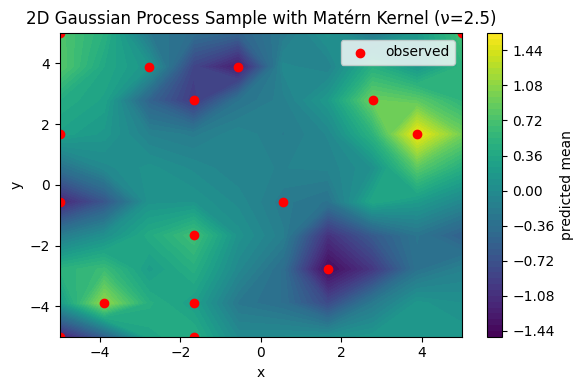

 
inference time: 5.0471742153167725 sec , for 500 samples


In [ ]:
mean_16pts,std_16pts=Inference_2d(n_samples=500,sample_func=sample_fn_1)

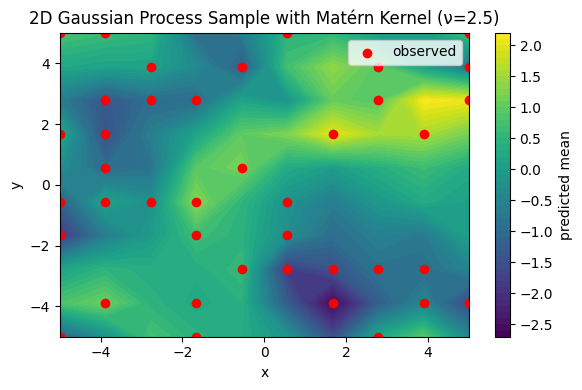

 
inference time: 7.0154054164886475 sec , for 500 samples


In [ ]:
mean_16pts,std_16pts=Inference_2d(n_samples=500)

In [ ]:
#@title masked image

def plot2D_mask(title,obs_idx=obs_idx, vector=samples.numpy(),cbar=False,labels=False):
    # Step 3: Create a mask for non-selected locations
    mask = np.ones_like(samples.numpy(), dtype=bool)  # Initialize mask as True (all points masked)
    mask = mask.flatten()  # Flatten the mask
    mask[obs_idx] = False  # Unmask selected points
    masked_samples = np.ma.array(samples.numpy(), mask=mask.reshape(N, N))  # Mask the non-selected points
    # Create a colormap and set the color for masked values (black)
    cmap = plt.cm.viridis
    cmap.set_bad(color='black')  # Set color for masked values
    plt.imshow(masked_samples, cmap=cmap, extent=(-5, 5, -5, 5), origin='lower')
    if cbar==True:
          plt.colorbar()
    # Customize plot appearance
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    plt.xticks([])  # Removes x-axis ticks
    plt.yticks([])  # Removes y-axis ticks
    plt.title(title)
    if labels==True:
        plt.xlabel('x')
        plt.ylabel('y')
    # plt.legend()
    #plt.tight_layout()  # Adjust layout to fit everything nicely


def plot2D_reconst(vector,title,cbar=False,points=False,labels=False):
  samples = vector.reshape(N, N)  # Generate 1 sample and reshape to 2D grid
  # Step 6: Plot the GP sample with the noisy points and the 8 random points
  #plt.figure(figsize=(6, 4))  # Increase figure size for better fitting
  cmap = plt.cm.viridis
  plt.imshow(samples, cmap=cmap, extent=(-5, 5, -5, 5), origin='lower')
  if cbar==True:
      plt.colorbar(label="f(x,y)")
      plt.legend()
  # Ensure the plot fits the map
  plt.xlim([-5, 5])
  plt.ylim([-5, 5])
  plt.xticks([])  # Removes x-axis ticks
  plt.yticks([])  # Removes y-axis ticks
  plt.title(title)
  if labels==True:
      plt.xlabel('x')
      plt.ylabel('y')

  plt.tight_layout()  # Adjust layout to fit everything nicely


def plot2D(vector,title,x_obs=x_obs,cbar=False,points=False,labels=False):
  samples = vector.reshape(N, N)  # Generate 1 sample and reshape to 2D grid
  # Step 6: Plot the GP sample with the noisy points and the 8 random points
  #plt.figure(figsize=(6, 4))  # Increase figure size for better fitting
  plt.contourf(X_grid.numpy(), Y_grid.numpy(), samples, cmap='viridis', levels=50)
  if cbar==True:
      plt.colorbar()
  if points==True:
  # Mark noisy points on the grid
      plt.scatter(x_obs[:, 0], x_obs[:, 1], color='r', marker='o')

  # Ensure the plot fits the map
  plt.xlim([-5, 5])
  plt.ylim([-5, 5])
  plt.xticks([])  # Removes x-axis ticks
  plt.yticks([])  # Removes y-axis ticks
  plt.title(title)
  if labels==True:
      plt.xlabel('x')
      plt.ylabel('y')
  #plt.legend()
  plt.tight_layout()  # Adjust layout to fit everything nicely



In [ ]:

std_2D=[std_16pts,std_40pts]
mean_2D=[mean_16pts,mean_40pts]
x_obs_2D=[x_obs1,x_obs2]
idx=[id1,id2]

title_mean=["inferred mean: 16 points","inferred mean: 32 points"]
title_std=["standard deviation: 16 points","standard deviation: 32 points"]
title_obs=["observed: 16 points" ,"observed: 32 points"]
title_rec=["reconstructed: 16 points","reconstructed: 32 points"]


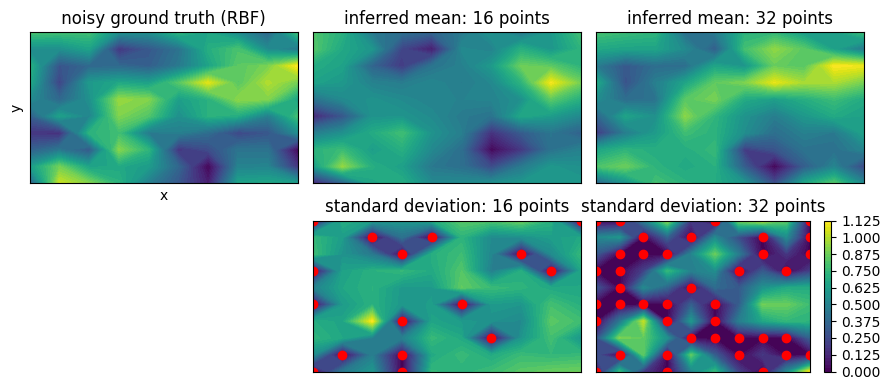

In [ ]:
fig = plt.figure(figsize=(9,4))
fig.add_subplot(2, 3, 1)
plot2D(vector=noisy_samples,title=" noisy ground truth (RBF) ",points=False,labels=True)
for i in range(0,2):
    j=i+2
    fig.add_subplot(2, 3, j)

    plot2D(vector=mean_2D[i],x_obs=x_obs_2D[i],title=title_mean[i],points=False,cbar=False)

for i in range(0,2):
    j=(i+1)+4
    fig.add_subplot(2, 3, j)
    if j==6:
        cbar=True
    else:
        cbar=False
    plot2D(vector=std_2D[i],x_obs=x_obs_2D[i],title=title_std[i],points=True,cbar=cbar)

In [ ]:
fig.savefig('Simfor_2D_exp1_Matern_kernel_fig1.png')
#fig.savefig('Simfor_2D_exp1_Matern_kernel_fig1.pdf')

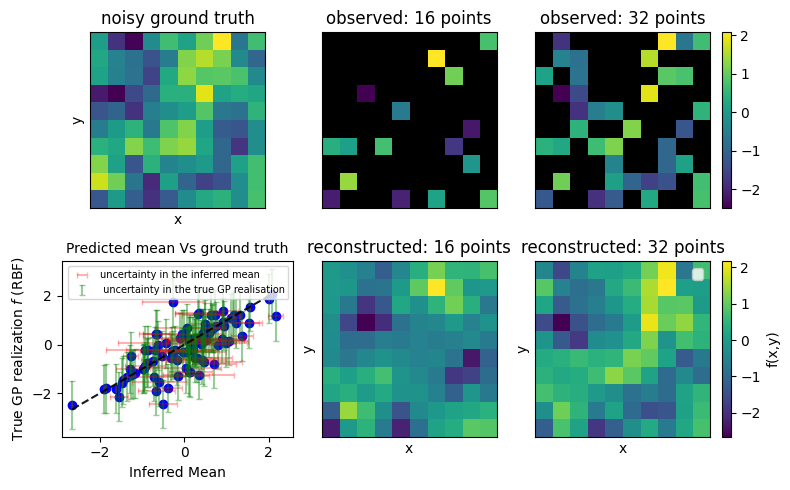

In [ ]:
fig = plt.figure(figsize=(8,5))
fig.add_subplot(2, 3, 1)
plot2D_reconst(vector=noisy_samples.numpy(),title="noisy ground truth",labels=True)
for i in range(0,2):
    j=i+2
    fig.add_subplot(2, 3, j)
    if  j==3:
        cbar=True
    else:
        cbar=False
    plot2D_mask(obs_idx=idx[i],title=title_obs[i],cbar=cbar)

for i in range(0,2):
    j=(i+1)+4
    fig.add_subplot(2, 3, j)
    if j==6:
        cbar=True
    else:
        cbar=False
    plot2D_reconst(vector=mean_2D[i],title=title_rec[i],cbar=cbar,labels=True)

fig.add_subplot(2, 3, 4)
uncertainty()

plt.subplots_adjust(wspace=0)

In [ ]:
fig.savefig('Simfor_2D_exp2_Matern_kernel_fig3.svg')
fig.savefig('Simfor_2D_exp2_Matern_kernel_fig3.pdf')

In [ ]:
std_true=np.std(np.array(gp.sample((5000,))) , axis=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,4))
# Example data: vectors for x, y, and their standard deviations
y = noisy_samples.numpy()
x = mean_40pts
x_std = std_40pts  # Standard deviation for x (horizontal)
y_std = std_true   # Standard deviation for y (vertical)

def uncertainty():
      # Scatter plot with transparent points
      plt.scatter(x, y, color='blue', alpha=1)  # Adjust alpha for transparency

      # Add horizontal error bars (x_std) with transparency and red color
      plt.errorbar(x, y, xerr=x_std, fmt='none', ecolor='red', alpha=0.3, capsize=2, label='uncertainty in the inferred mean')

      # Add vertical error bars (y_std) with transparency and green color
      plt.errorbar(x, y, yerr=y_std, fmt='none', ecolor='green', alpha=0.4, capsize=2,linestyle='--', label=' uncertainty in the true GP realisation')

      # Add the dashed line y = x with transparency
      x_line = np.linspace(min(x), max(x), 100)  # Generate x values for the line
      plt.plot(x_line, x_line, color='black', linestyle='--', alpha=0.9,label='y=x')  # Transparent dashed line

      #plt.xticks(ticks=np.linspace(min(x), max(x), 5).astype(int))  # Adjust x-axis ticks to integers
      #plt.yticks(ticks=np.linspace(min(y), max(y), 5).astype(int))

      # Add labels and title
      plt.xlabel('Inferred Mean')
      plt.ylabel('True GP realization $f$ (RBF)')
      plt.title('Predicted mean Vs ground truth',fontsize=10)

      # Display legend and grid
      plt.legend(fontsize=7)
      plt.tight_layout()
      #plt.grid(True)
      #plt.show()


<Figure size 500x400 with 0 Axes>

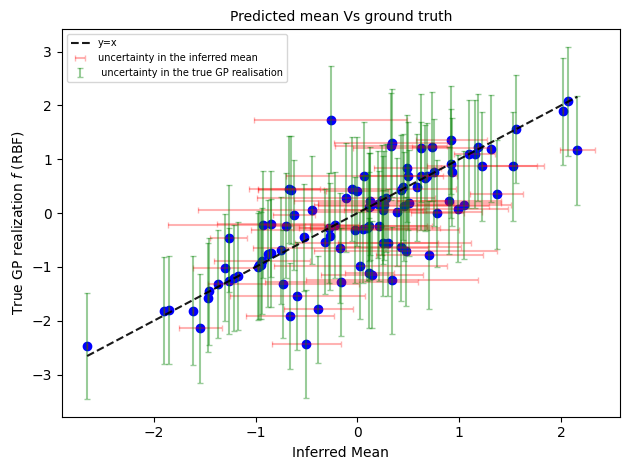

In [ ]:
uncertainty()

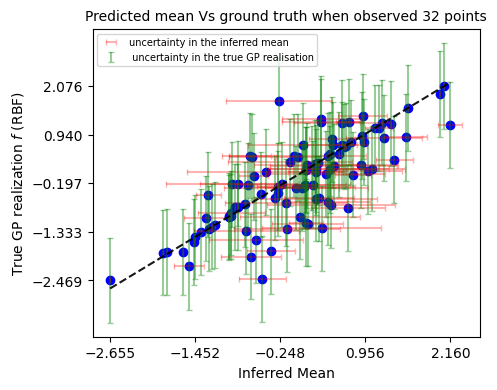

In [ ]:
fig